<img src="img/dsci572_header.png" width="600">

# Lecture 5: Training Neural Networks



<br><br><br>

## Lecture Learning Objectives


- Explain how backpropagation works at a high level

- Describe the difference between training loss and validation loss when creating a neural network
- Identify and describe common techniques to avoid overfitting/apply regularization to neural networks, e.g., early stopping, drop out, L2 regularization
- Use `PyTorch` to develop a fully-connected neural network and training pipeline

<br><br><br>

## Imports


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, TensorDataset
from utils.plotting import *

import plotly.io as pio
pio.renderers.default = "png"

<br><br><br>

## Differentiation, Backpropagation, Autograd


- In previous lectures we've discussed optimization algorithms like gradient descent, stochastic gradient descent, ADAM, etc.

- These algorithms need the gradient of the loss function w.r.t the model parameters to optimize the parameters

<br><br><br>

- We've been able to calculate the gradient analytically for linear and logistic regression

- But how would you work out the gradient for this *very* simple network for regression:

![](img/backprop-1.png)

- The equation for calculating the output of that network is below, it's the linear layers and activation functions (Sigmoid in this case) recursively stuck together:

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

$$\hat{y}=w_3\sigma(w_1x+b_1) + w_4\sigma(w_2x+b_2) + b_3$$

- So how would we calculate the gradient of say the MSE loss w.r.t to all our parameters?

$$\mathcal{L}(\mathbf{w}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2$$ 

$$\nabla \mathcal{L}(\mathbf{w}) = \begin{bmatrix} \frac{\partial L}{\partial w_1} \\ \frac{\partial L}{\partial w_2} \\ \vdots \\ \frac{\partial L}{\partial w_d} \end{bmatrix}$$

<br><br><br>

We have 3 options:

1. **Symbolic differentiation**: analytical derivation or "do it by hand", like we learned in calculus.

2. **Numerical differentiation**: using finite difference methods $\frac{df}{dx} \approx \frac{f(x+h)-f(x)}{h}$.

3. **Automatic differentiation**: breaking down computations into elementary sequential steps (the derivatives of which we know analytically), and using the chain rule

We'll be looking at Automatic Differentiation (AD) to train neural networks.

If you're interested in learning more about the other methods, see [Appendix C](appendixC_computing-derivatives.ipynb)

<br><br><br>

- Let's go through a short example based on this network:

![](img/backprop-2.png)

<br><br><br>

- Let's decompose that into smaller operations. Let's introduce some new variables to hold intermediate states $z_i$ (node output before activation) and $a_i$ (node output after activation)

- We'll feed in one sample data point `(x, y)` = `(1, 3)`.
- Let's carry out forward pass. 
- We're showing intermediate outputs in green and the final loss in red. 

![](img/backprop-3.png)

<br><br><br>

- Now let's zoom in to the output node and calculate the gradients for just the parameters connected to that node

- It looks complicated but the derivatives are very simple; take some time to examine this figure.

![](img/backprop-4.png)

We want to determine the impact of the weight $w_3$ on the loss $\mathcal{L}$. Note that $w_3$ is not explicitly part of the loss function $\mathcal{L} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y_i})^2$. 

However, $w_3$ influences the loss indirectly through the calculation of $\hat{y}$. A change in $w_3$ influences the prediction $\hat{y}$, which is then used in the calculation of the loss $\mathcal{L}$. 

To compute gradient of $\mathcal{L}$ with respect to $w_3$, we need to track these cascade of effects using the chain rule. Here is how we apply it in this context: 

$$\frac{\partial{\mathcal{L}}}{\partial{w_3}} = \frac{\partial{\mathcal{L}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{w_3}}$$

- From $w_3$ to $\hat{y}$: $\frac{\partial{\hat{y}}}{\partial{w_3}}$ = $\frac{\partial{(w_3a_1 + w_4a_2 + b_3)}}{\partial{w_3}} = a_1$ because $w_4$, $a_1$, $a_2$, and $b_3$ are constants when we calculate derivative with respect to $w_3$. 
- From $\hat{y}$ to $\mathcal{L}$: The $\frac{\partial{L}}{\partial{\hat{y}}}$ in this context is the derivative of MSE loss function and we have calculated it as -3.31. So, 
$$\frac{\partial{\mathcal{L}}}{\partial{w_3}} = \frac{\partial{\mathcal{L}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{w_3}} = -3.31 \times a_1$$

Similarly, 

$$\frac{\partial{\mathcal{L}}}{\partial{w_4}} = \frac{\partial{\mathcal{L}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{w_4}} = -3.31 \times a_2$$

<br><br><br>

- That all boils down to this:

![](img/backprop-5.png)

<br><br><br>

- Now, the beauty of backpropagation is that we can use these results to easily calculate derivatives earlier in the network using the *chain rule*

- I'll do that for $b_1$ and $b_2$ below

- Once again, it looks complicated, but we're simply combining a bunch of small, simple derivatives with the chain rule.

![](img/backprop-6.png)

**Note:** $ \frac{d}{dx} \sigma (x) =  \sigma (x) (1 - \sigma (x))$, where $\sigma (x) = \text{Sigmoid}(x)$ in this example.

We want to determine the impact of the bias $b_1$ on the loss $\mathcal{L}$. Note that $b_1$ is not explicitly part of the loss function $\mathcal{L}$. It influences the loss indirectly through a series of calculations within the network. 
- A change in $b_1$ alters the weighted input $z_1 = w_1x + b_1$. 
- This change in $z_1$ modifies the activation $a_1$, which is the output of the sigmoid function applied to $z_1$.
- The activation $a_1$ then contributes to the subsequent layer's computations, ultimately influencing the predicted output $\hat{y}$.
- Finally, $\hat{y}$ is used in the calculation of the loss $\mathcal{L}$. 

To compute the gradient of $\mathcal{L}$ with respect to $b_1$, we need to track this cascade of effects using the chain rule, which will allow us to connect the rate of change of each variable in the pathway from $b_1$ to $\mathcal{L}$.  

$$\frac{\partial{L}}{\partial{b_1}} = \frac{\partial{L}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{a_1}}\frac{\partial{a_1}}{\partial{z_1}}\frac{\partial{z_1}}{\partial{b_1}}$$

- From $b_1$ to $z_1$: $z_1$ is a linear combination $w_1x + b_1$. Since $w_1$ and $x$ are constant when calculating the derivative wrt $b_1$, $\frac{\partial{z_1}}{\partial{b_1}} = 1$  
- From $z_1$ to $a_1$: The derivative of a sigmoid function $\sigma(z_1)$ with respect to $z_1$ is $\sigma(z_1).\sigma(1-\sigma{z_1})$. Since $a_1 = \sigma{z_1}$, this simplifies to $a_1.(1 - a_1) = 0.88 \times (1 - 0.88) = 0.1056$
- From $a_1$ to $\hat{y}$: This part requires understanding how $a_1$ is used to calculate $\hat{y}$. $\frac{\partial{\hat{y}}}{\partial{a_1}} = \frac{\partial{(w_3a_1 + w_4a_2 + b_3)}}{\partial{a_1}} = w_3 = 1$
- From $\hat{y}$ to $\mathcal{L}$: The $\frac{\partial{L}}{\partial{\hat{y}}}$ in this context is the derivative of MSE loss function and we have calculated it as -3.31. So,

$$\frac{\partial{L}}{\partial{b_1}} = \frac{\partial{L}}{\partial{\hat{y}}}\frac{\partial{\hat{y}}}{\partial{a_1}}\frac{\partial{a_1}}{\partial{z_1}}\frac{\partial{z_1}}{\partial{b_1}} = -3.31 \times 1 \times 0.11 \times 1 = -0.35$$

This gradient tells us how small changes in $b_1$ will affect the overall loss $\mathcal{L}$, guiding us in updating the bias $b_1$, during the training process to minimize $\mathcal{L}$. 

In [2]:
((0.88)*(1 - 0.88))

0.1056

In [3]:
-3.31 * 1 * ((0.88)*(1 - 0.88)) * 1

-0.349536

<br><br><br>

- I've left calculating the gradients of $w_1$ and $w_2$ up to you

- All the gradients for the network boil down to this:

![](img/backprop-7.png)

<br><br><br>

- So summarizing the process:

    1. Do one "forward pass" of the data through the network to compute the loss value

    2. Do one "backward pass" through the network to calculate gradients of the loss w.r.t parameters

- The **backward pass** above is actually a special case of automatic differentiation called **reverse-mode automatic differentiation**

- In the context of neural networks, the process of computing gradients of the loss w.r.t. model parameters using reverse-mode automatic differentiation is known as the **backpropagation algorithm**. 

<br><br><br>

### Autograd

- `torch.autograd` is PyTorch's automatic differentiation engine which helps us implement backpropagation

- In simple terms, `torch.autograd` automatically calculates and stores derivatives for your network

- Consider our simple network above:

![](img/backprop-2.png)

Let's create a PyTorch class for our toy network. 

In [4]:
class network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = torch.sigmoid(x)
        x = self.output(x)
        return x

In [5]:
model = network(1, 2, 1)  # make an instance of our network
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 0.8355],
                      [-0.4987]])),
             ('hidden.bias', tensor([-0.9836, -0.0756])),
             ('output.weight', tensor([[0.2069, 0.3347]])),
             ('output.bias', tensor([-0.1863]))])

Current weights are randomly initialized. Let's initialize them according to our toy network. 

In [6]:
model.state_dict()['hidden.weight'][:] = torch.tensor([[1], [-1]])  # fix the weights manually based on the earlier figure
model.state_dict()['hidden.bias'][:] = torch.tensor([1, 2])
model.state_dict()['output.weight'][:] = torch.tensor([[1, 2]])
model.state_dict()['output.bias'][:] = torch.tensor([-1])
x, y = torch.tensor([1.0]), torch.tensor([3.0])  # our x, y data

<br><br><br>

- Now let's check the gradient of the bias of the output node:

In [7]:
print(model.output.bias.grad)

None


- It's currently `None`

- PyTorch is tracking the operations in our network and how to calculate the gradient, but it hasn't calculated anything yet because we don't have a loss function and we haven't done a forward pass to calculate the loss so there's nothing to backpropagate yet
- Let's define a loss now:

In [8]:
criterion = torch.nn.MSELoss()

- Now we can force Pytorch to "backpropagate" the errors, like we just did by hand earlier by:

    1. Doing a "forward pass" of our `(x, y)` data and calculating the `loss`;
    
    2. "Backpropagating" the loss by calling `loss.backward()`

In [9]:
loss = criterion(model(x), y)
loss.backward()

- Now let's check the gradient of the bias of the output node ($\frac{\partial L}{\partial b_3}$):

In [10]:
print(model.output.bias.grad)

tensor([-3.3142])


- It matches what we calculated earlier!

![](img/backprop-8.png)

<br><br><br>

- We can make sure that all our gradients match what we calculated by hand:

In [11]:
print("Hidden Layer Gradients")
print("Bias:", model.hidden.bias.grad)
print("Weights:", model.hidden.weight.grad.squeeze())
print()
print("Output Layer Gradients")
print("Bias:", model.output.bias.grad)
print("Weights:", model.output.weight.grad.squeeze())

Hidden Layer Gradients
Bias: tensor([-0.3480, -1.3032])
Weights: tensor([-0.3480, -1.3032])

Output Layer Gradients
Bias: tensor([-3.3142])
Weights: tensor([-2.9191, -2.4229])


<br><br><br>

- Now that we have the gradients, what's the next step? We use our optimization algorithm to update our weights

- These are our current weights:

In [12]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 1.],
                      [-1.]])),
             ('hidden.bias', tensor([1., 2.])),
             ('output.weight', tensor([[1., 2.]])),
             ('output.bias', tensor([-1.]))])

- To optimize them, we:

    1. Define an `optimizer`,
    
    2. Ask it to update our weights based on our gradients using `optimizer.step()`.

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer.step()

- Our weights should now be different:

In [14]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 1.0348],
                      [-0.8697]])),
             ('hidden.bias', tensor([1.0348, 2.1303])),
             ('output.weight', tensor([[1.2919, 2.2423]])),
             ('output.bias', tensor([-0.6686]))])

<br><br><br>

- One last thing for you to know: **PyTorch does not automatically clear the gradients** after using them

- So if I call `loss.backward()` again, my gradients accumulate:

In [15]:
optimizer.zero_grad()  # <- I'll explain this in the next cell

for _ in range(1, 6):

    loss = criterion(model(x), y)
    loss.backward()
    
    print(f"b3 gradient after call {_} of loss.backward():", model.hidden.bias.grad)

b3 gradient after call 1 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 2 of loss.backward(): tensor([-0.3983, -1.1953])
b3 gradient after call 3 of loss.backward(): tensor([-0.5974, -1.7929])
b3 gradient after call 4 of loss.backward(): tensor([-0.7966, -2.3906])
b3 gradient after call 5 of loss.backward(): tensor([-0.9957, -2.9882])


- Our gradients are accumulating each time we call `loss.backward()`

- So we need to tell PyTorch to "zero the gradients" in each iteration using `optimizer.zero_grad()`:

- If you don't reset the gradients after each update, the gradients computed by subsequent backward passes will add to the existing gradients rather than replacing them. This leads to incorrect gradient values, as each pass's gradients will be influenced by the previous passes, rather than solely reflecting the current pass.

In [16]:
for _ in range(1, 6):

    optimizer.zero_grad()  # <- don't forget this
    
    loss = criterion(model(x), y)
    loss.backward()

    print(f"b3 gradient after call {_} of loss.backward():", model.hidden.bias.grad)

b3 gradient after call 1 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 2 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 3 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 4 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 5 of loss.backward(): tensor([-0.1991, -0.5976])


<br><br><br>

**Note**: You might wonder why PyTorch behaves like this. There are two notable reasons for this:

1. It is a common situation that we want to use a certain batch size but we can't, due to hardware limitations. In order to imitate a large batch size, we can use smaller batches and compute gradients in each iteration, and instead of updating the weights, we can simply accumulate the gradients for a certain number of iterations. Since the gradient is the sum of contributions from each data point, we can wait for as many iterations as we want, and only then update the weights using the accumulated gradient. In this way, we have effectively used a large batch size without causing potential memory problems.

2. When our overall loss is the sum of multiple losses, we would want to accumulate gradients when we do `.backward()` on each loss so as to be able to arrive at the gradient of the overall loss in the end.

<br><br><br>

### (Optional) Computational Graph 

PyTorch's `autograd` basically keeps a record of our data and network operations in a computational graph. That's beyond the scope of this lecture, but if you're interested in learning more, I recommend this [blog post](https://pytorch.org/blog/overview-of-pytorch-autograd-engine/) from Pytorch's website.

Also, `torchviz` is a useful package to look at the "computational graph" PyTorch is building for us under the hood. For using `torchviz`, you should first install `graphviz` using this [link](https://graphviz.org/download/), and then install `torchviz` using pip:
```bash
pip install torchviz
```

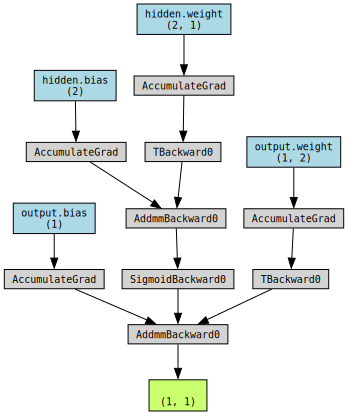

In [17]:
import torchviz
torchviz.make_dot(model(torch.ones(1, 1)), params=dict(model.named_parameters()))

The graph represents the flow of data and the operations applied to the data as it moves through the network during the backward pass. 

- **Nodes and Tensors**: The blue rectangles (`hidden.weight`, `hidden.bias`, `output.weight`, and `output.bias`) represent tensors, which are parameters of the network. The dimensions of each tensor are shown in parenthesis. 
- **Operations**: The gray rectangles represent operations.
- **Edges**: The arrows indicate the direction of the computation flow.
- The green rectangle represents the output tensor representing the loss or the final output of the model.  

<br><br><br>

## Vanishing/Exploding Gradients

- The backpropagation algorithm uses the chain rule to compute the gradients

- The chain rule involves multiplying potentially many terms together (depending on the depth of our neural network)

- Therefore, we are potentially in danger of vanishing/exploding computations

<br><br><br>

- Especially when using activation functions such as sigmoid, the situation gets worse:

<img src="http://ronny.rest/media/blog/2017/2017_08_10_sigmoid/sigmoid_and_derivative_plot.jpg" width="600">

([image source](http://ronny.rest/media/blog/2017/2017_08_10_sigmoid/sigmoid_and_derivative_plot.jpg))

- **Sigmoid function:** approaches 0 for large negative values and approaches 1 for large positive values
- **Derivative of Sigmoid:** Highest value of around 0.25 at the input value 0 and it rapidly approaches 0 as the input moves towards positive or negative infinity.
- **Vanishing gradients:** Derivatives become very small when the input is far from 0. This small gradient value (close to 0) when propogated through multiple layers of a deep network will multiply with other small gradients. With each multiplication, the gradient gets exponentially smaller, leading to vanishing gradients. This is problematic because it means that nodes in the earlier layers of the networks received very small updates and learn very slowly, if at all.
- **Exploding gradients:** This is less common with sigmoid. Exploding gradients can occur during the backpropagation if the gradients are large and multiplying several of them results in a large value.    

Possible solutions:

- Using the ReLU activation

- Batch normalization

- Change learning rate

- ResNets

- Changing network architecture

- Gradient clipping

- Different weight initialization

<br><br><br>

## Training Neural Networks


- The big takeaway from the last section is that PyTorch's `autograd` takes care of the gradients for us

- We just need to put all the pieces together properly
- Remember the below `trainer()` function we used in the last lecture to train our network
- Now we know what all this means:

In [18]:
def trainer(model, criterion, optimizer, dataloader, epochs=5):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    
    for epoch in range(epochs):  # for each epoch
        losses = 0
        
        for X, y in dataloader:  # for each batch
            
            optimizer.zero_grad()            # Zero all the gradients w.r.t. parameters
            
            y_hat = model(X).flatten()       # Forward pass to get output
            loss = criterion(y_hat, y)       # Calculate loss based on output
            loss.backward()                  # Calculate gradients w.r.t. parameters
            optimizer.step()                 # Update parameters

            losses += loss.item()            # Add loss for this batch to running total
            
        train_loss.append(losses / len(dataloader))  # loss = total loss in epoch / number of batches = loss per batch
        
    return train_loss

- Notice how I calculate the loss for each epoch by summing up the loss for each batch in that epoch

- I then divide the loss for each epoch by the total number of batches to get the average loss per batch in an epoch

- If our model is being trained correctly, our loss should go down over time. Let's try it out with some sample data:

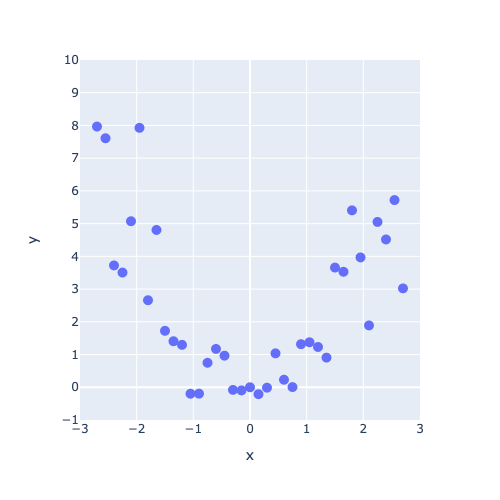

In [19]:
torch.manual_seed(0)

X = torch.arange(-3, 3, 0.15)
y = X ** 2 + X * torch.normal(0, 1, (40,))

dataloader = DataLoader(TensorDataset(X[:, None], y), batch_size=1, shuffle=True)

plot_regression(X, y, y_range=[-1, 10], dy=1)

In [20]:
model = network(1, 3, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [21]:
train_loss = trainer(model, criterion, optimizer, dataloader, epochs=101)

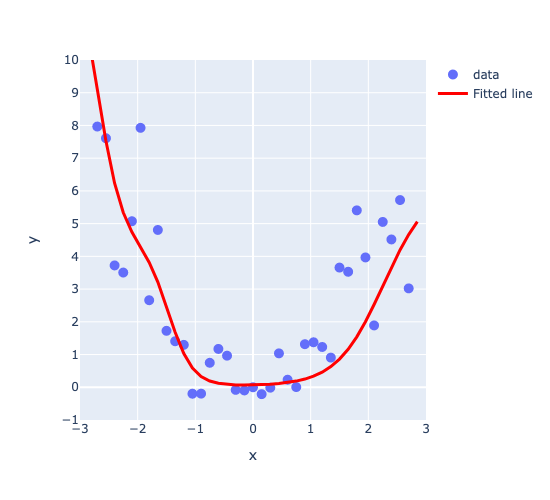

In [22]:
plot_regression(X, y, model(X[:, None]).detach(), y_range=[-1, 10], dy=1)

- The model looks like a good fit, so presumably the loss went down as epochs progressed, let's take a look:

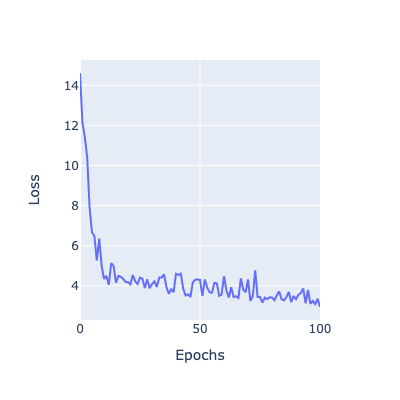

In [23]:
plot_loss(train_loss)

<br><br><br>

### Validation Loss

- We've been focusing on training loss so far, but as we know, we need to validate our model on new **unseen** data

- For this, we'll need some validation data. I'm going to split our dataset in half to create a `trainloader` and a `validloader`:

In [24]:
# Create dataset
torch.manual_seed(0)

X_valid = torch.arange(-3.0, 3.0)
y_valid = X_valid ** 2

trainloader = DataLoader(TensorDataset(X, y), batch_size=1, shuffle=True)
validloader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=1, shuffle=True)

- The wonderful thing about PyTorch is that you are in full control, you can do whatever you want

- So here, after each epoch, I'm going to record the validation loss by looping over my validation batches, it's just a little extra module I add to my training function:

In [25]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:

            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters

            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters

            train_batch_loss += loss.item()  # Add loss for this batch to running total

        train_loss.append(train_batch_loss / len(trainloader))
        
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood

            for X_valid, y_valid in validloader:

                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = criterion(y_hat, y_valid)  # Calculate loss based on output

                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))
        
    return train_loss, valid_loss

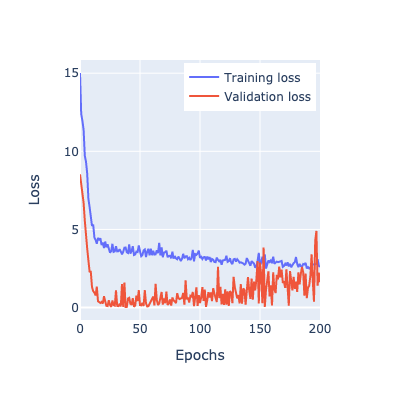

In [26]:
model = network(1, 6, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
train_loss, valid_loss = trainer(model, criterion, optimizer, trainloader, validloader, epochs=201)

plot_loss(train_loss, valid_loss)

- What do we see above?

- Well, we're obviously overfitting. We are optimizing too well

- One way we could avoid overfitting is by terminating the training if our validation loss starts going up, this is called **early stopping**

<br><br><br>

### Early stopping

- Early stopping is one way of avoiding overfitting

- As training progresses, if we notice the validation loss increasing (while the training loss is decreasing), that's usually an indication of overfitting
- The validation loss may go up and down from epoch to epoch, so usually we define a **patience** parameter which is a number of consecutive epochs we're willing to allow the validation loss to increase before we stop
- The beauty of PyTorch is how easy and intuitive it is to customize your network in this way, unlike with TensorFlow

In [27]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:
            
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters

            train_batch_loss += loss.item()  # Add loss for this batch to running total
            
        train_loss.append(train_batch_loss / len(trainloader))
        
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time

            for X_valid, y_valid in validloader:

                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = criterion(y_hat, y_valid)  # Calculate loss based on output

                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
        
    return train_loss, valid_loss

Stopped early at epoch 53 - val loss increased for 3 consecutive epochs!


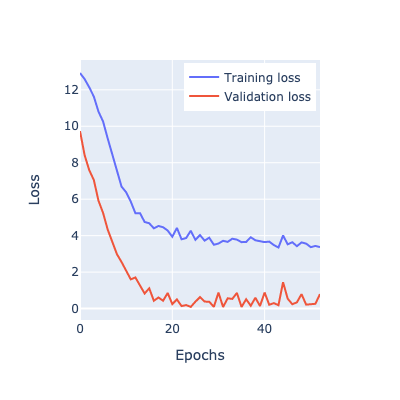

In [28]:
torch.manual_seed(1)

model = network(1, 6, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
train_loss, valid_loss = trainer(model, criterion, optimizer, trainloader, validloader, epochs=201, patience=3)

plot_loss(train_loss, valid_loss)

- There are more advanced implementations of early stopping out there, but the idea is the same

<br><br><br>

## Regularization


- Recall that regularization is a technique to help avoid overfitting

- There are many regularization techniques available in neural networks

- I'll discuss the two main ones here:

    1. Drop out
    
    2. L2 regularization

<br><br><br>

### Drop Out

- Drop out is a common regularization technique and is very simple

- Basically, each iteration, we randomly choose some neurons in a layer and don't update their weights (to do this we set the output of the nodes to 0)
- A simple example:

In [29]:
dropout_layer = torch.nn.Dropout(p=0.5)  # 50% probability that a node will be set to 0 ("dropped out")
inputs = torch.randn(5, 3)
inputs

tensor([[-0.6463,  2.0122, -0.9234],
        [ 0.6294,  0.4905,  1.2263],
        [-2.0088, -0.9414,  0.4696],
        [-1.2196,  0.5989,  1.7997],
        [ 1.0764,  1.0841, -0.1575]])

In [30]:
dropout_layer(inputs)

tensor([[-1.2926,  0.0000, -1.8468],
        [ 0.0000,  0.0000,  2.4525],
        [-0.0000, -0.0000,  0.0000],
        [-2.4391,  1.1978,  0.0000],
        [ 0.0000,  2.1683, -0.3150]])

- In the above, note how about 50% of nodes have been given a value of 0

<br><br><br>

### L2 Regularization

- Recall that in L2 we had this penalty to the loss: $\frac{\lambda}{2}||w||^2$

- $\lambda$ is the regularization parameter

- L2 regularization is called "weight-decay" in PyTorch, the value of which specifies $\lambda$

- It's an argument in most optimizers which you can specify:

In [31]:
torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0.5
)

Each weight is decayed or shrunk by a factor proportional to its current value. This discourages the optimizer from allowing weights to grow too large unless they significantly decrease the loss function. 

<br><br><br>

## Lecture Exercise: Putting it all Together with Bitmojis


- Let's put everything we learned in this lecture together to predict some bitmojis

- I have a folder of images with the following structure:

```
data
└── bitmoji
    ├── train
    │   ├── eva
    │   └── not_eva
    └── valid
        ├── eva
        └── not_eva
```

In [32]:
TRAIN_DIR = "data/eva_bitmoji_rgb/train/"
VALID_DIR = "data/eva_bitmoji_rgb/valid/"

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64

data_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convert image to RGB    
    transforms.Resize(IMAGE_SIZE),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Training data
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation data
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

{'eva': 0, 'not_eva': 1}
tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


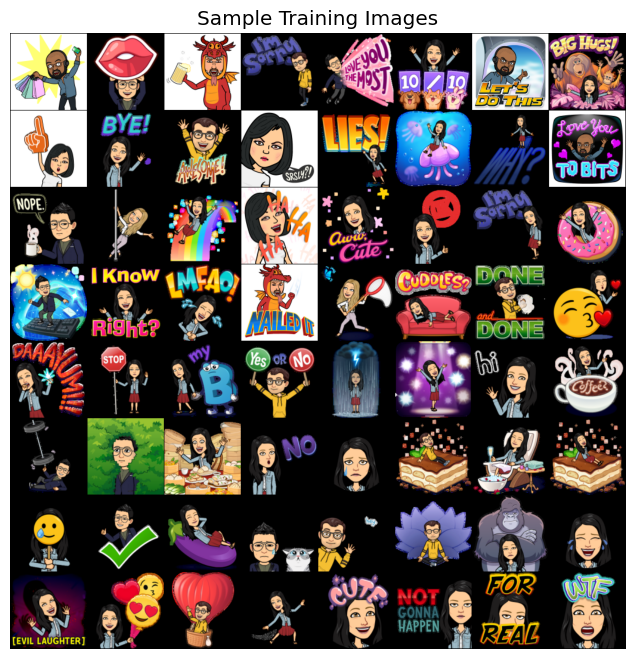

In [33]:
print(train_dataset.class_to_idx)  # See which labels are assigned to each class
sample_batch = next(iter(train_loader))
plot_bitmojis(sample_batch)
print(sample_batch[1])

<br><br><br>

- Now the network

- I'm going to make a function `linear_block()` to help create my network and keep things DRY:

In [34]:
def linear_block(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.LeakyReLU(),
        nn.Dropout(0.1)
    )

class BitmojiClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.main = nn.Sequential(
            linear_block(input_size, 128),
            linear_block(128, 64),
            linear_block(64, 32),
            linear_block(32, 16),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        out = self.main(x)
        return out

- Now the training function

- This is getting long but it's just all the bits we've seen before!

In [35]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    consec_increases = 0
    
    for epoch in range(epochs):  # for each epoch
        
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:

            optimizer.zero_grad()                            # Zero all the gradients w.r.t. parameters

            #y_hat = model(X.view(X.shape[0], -1)).flatten()  # Forward pass to get output
            y_hat = model(X).squeeze()  # Forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5        # convert probabilities to False (0) and True (1)
            loss = criterion(y_hat, y.type(torch.float32))   # Calculate loss based on output            
            loss.backward()                                  # Calculate gradients w.r.t. parameters
            optimizer.step()                                 # Update parameters

            train_batch_loss += loss.item()                  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch
            
        train_loss.append(train_batch_loss / len(trainloader))     # loss = total loss in epoch / number of batches = loss per batch
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()  # this turns off those random dropout layers, we don't want them for validation!
        
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time

            for X, y in validloader:                
                #y_hat = model(X.view(X.shape[0], -1)).flatten()  # Forward pass to get output
                y_hat = model(X).squeeze()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5        # convert probabilities to False (0) and True (1)
                loss = criterion(y_hat, y.type(torch.float32))   # Calculate loss based on output

                valid_batch_loss += loss.item()                  # Add loss for this batch to running total
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch
                
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()  # turn back on the dropout layers for the next training loop
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1:3}: val loss increased for {consec_increases} consecutive epochs!")
            break
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "train_accuracy": train_accuracy,
               "valid_accuracy": valid_accuracy}
    return results

In [36]:
torch.manual_seed(1)

model = BitmojiClassifier(3 * IMAGE_SIZE[0] * IMAGE_SIZE[1])
# model = BitmojiClassifier(IMAGE_SIZE[0] * IMAGE_SIZE[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

results = trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=20, patience=4)

Epoch   1: Train Loss: 0.684. Valid Loss: 0.656. Train Accuracy: 0.53. Valid Accuracy: 0.55.
Epoch   2: Train Loss: 0.666. Valid Loss: 0.637. Train Accuracy: 0.56. Valid Accuracy: 0.58.
Epoch   3: Train Loss: 0.641. Valid Loss: 0.625. Train Accuracy: 0.62. Valid Accuracy: 0.59.
Epoch   4: Train Loss: 0.632. Valid Loss: 0.624. Train Accuracy: 0.62. Valid Accuracy: 0.60.
Epoch   5: Train Loss: 0.623. Valid Loss: 0.614. Train Accuracy: 0.64. Valid Accuracy: 0.61.
Epoch   6: Train Loss: 0.606. Valid Loss: 0.618. Train Accuracy: 0.66. Valid Accuracy: 0.61.
Epoch   7: Train Loss: 0.595. Valid Loss: 0.618. Train Accuracy: 0.67. Valid Accuracy: 0.62.
Epoch   8: Train Loss: 0.590. Valid Loss: 0.613. Train Accuracy: 0.66. Valid Accuracy: 0.59.
Epoch   9: Train Loss: 0.565. Valid Loss: 0.628. Train Accuracy: 0.69. Valid Accuracy: 0.59.
Epoch  10: Train Loss: 0.558. Valid Loss: 0.624. Train Accuracy: 0.70. Valid Accuracy: 0.59.
Epoch  11: Train Loss: 0.541. Valid Loss: 0.626. Train Accuracy: 0.72.

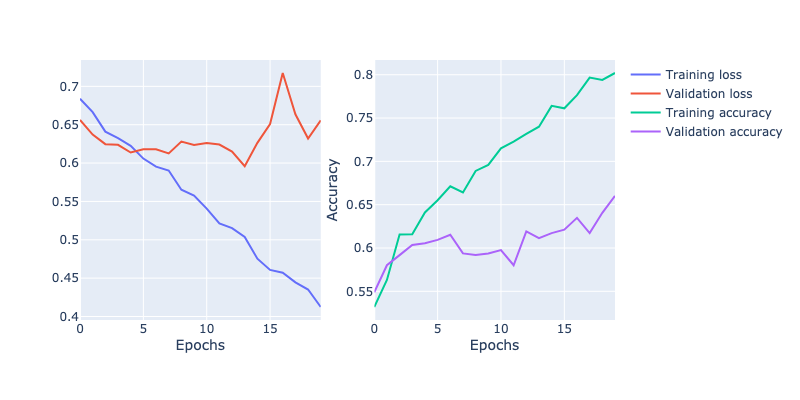

In [37]:
plot_loss(results["train_loss"], results["valid_loss"], results["train_accuracy"], results["valid_accuracy"])

- I couldn't get very good accuracy with this model and there's a reason for that: we're not considering the structure in our image

- We're flattening our images down into independent pixels, but the relationship between pixels is probably important

- We'll exploit that next lecture when we get to CNNs

- For now, let's see if our NN model can correctly classify Eva's bitmoji:

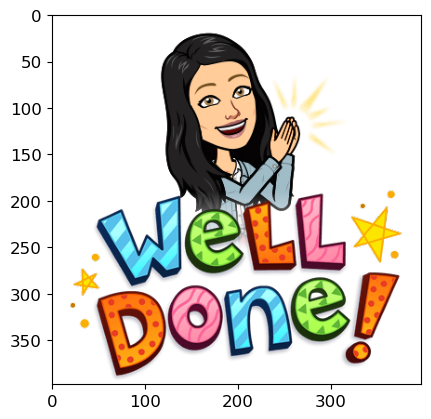

In [38]:
plt.imshow(plt.imread("img/test-examples/eva-well-done.png"));

In [39]:
IMAGE_SIZE

(128, 128)

In [40]:
from PIL import Image
import torch
from torchvision import transforms

torch.Size([1, 49152])
0


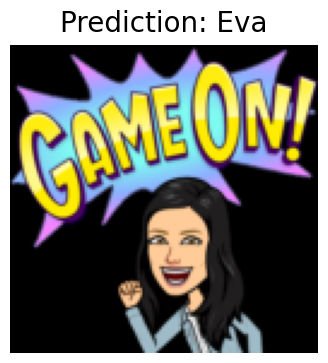

torch.Size([1, 49152])
0


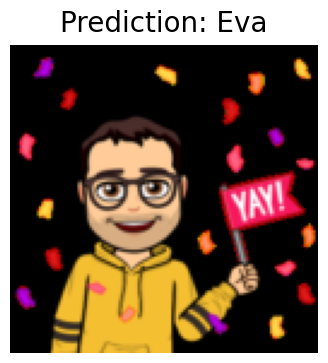

torch.Size([1, 49152])
0


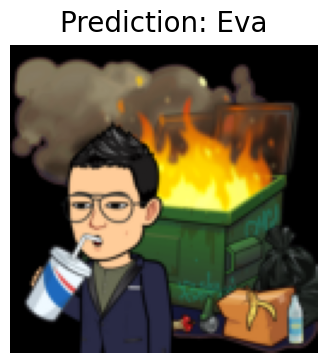

torch.Size([1, 49152])
1


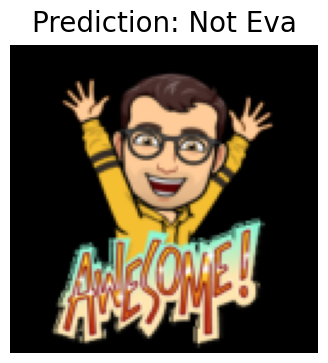

torch.Size([1, 49152])
0


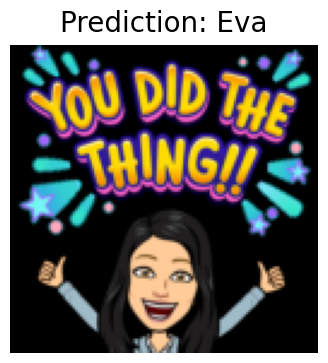

torch.Size([1, 49152])
0


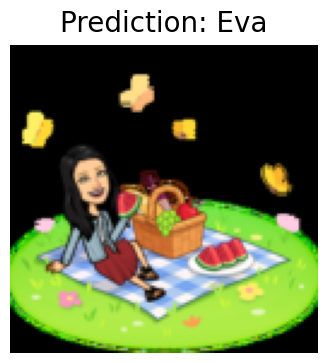

torch.Size([1, 49152])
0


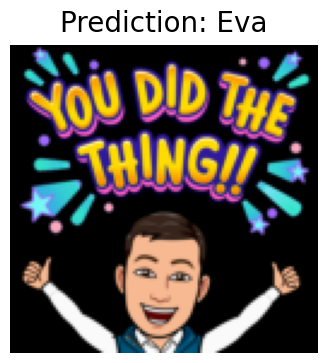

torch.Size([1, 49152])
0


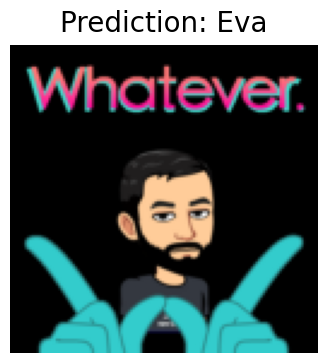

torch.Size([1, 49152])
0


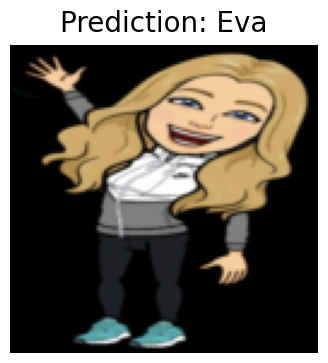

torch.Size([1, 49152])
0


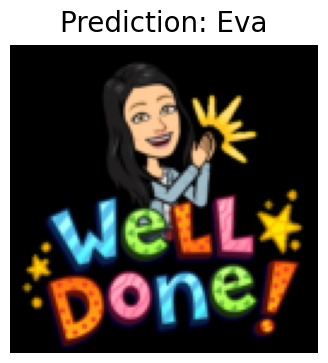

torch.Size([1, 49152])
1


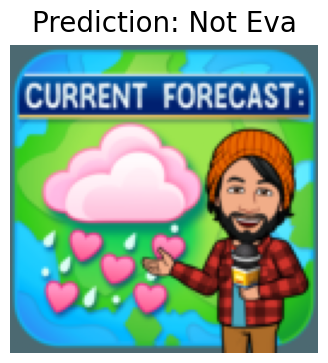

In [41]:
def predict_unseen(image_path): 
    image = Image.open(image_path)
    
    # Apply the transformations
    transformed_image = data_transforms(image)
    
    # Add a batch dimension (as model expects batches)
    transformed_image = transformed_image
    
    # Flatten the image
    flattened_image = transformed_image.view(1, -1)
    print(flattened_image.shape)
    # Make sure the flattened image has the correct shape
    assert flattened_image.shape == (1, 3* 128 * 128), "Image tensor shape is not matching model's input shape"
    
    # Make a prediction
    model.eval()
    with torch.no_grad():
        prediction = model(flattened_image)
        prediction = torch.sigmoid(prediction)
        label = int(prediction > 0.5)
        print(label)
    
    # Visualization
    plt.figure(figsize=(4, 4))
    plt.title(f"Prediction: {['Eva', 'Not Eva'][label]}", pad=10, fontsize=20)
    # Adjust the following line if working with RGB images
    plt.imshow(transformed_image.squeeze(0).permute(1, 2, 0))  # permute dimensions for RGB
    plt.axis('off')  # Hide axis
    plt.show()

import glob

for unseen_ex in glob.glob("img/test-examples/*"):
    predict_unseen(unseen_ex)


<br><br><br>

## Universal Approximation Theorem

- The [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that any continuous function can be approximated arbitrarily well by a neural network with at least 1 hidden layer with a finite number of weights.

- In other words, neural networks are universal function approximators.

- So, how come we weren't able to train a near-perfect image classifier in the previous section?

<br><br><br>

## Lecture Highlights


1. Neural network training in a nutshell: forward pass -> calculate loss -> backpropagate -> optimizer step -> repeat. In PyTorch we can customize this process with extras like calculating the loss or accuracy.

2. PyTorch takes care of calculating gradients for us with **autograd**.

3. Common ways to avoid overfitting: early stopping, drop out, L2 penalty.